<a href="https://colab.research.google.com/github/Saadkhalid913/ML-Practice/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
# !pip install kaggle 

In [85]:
import torchvision.transforms as transforms 
import torch.nn.functional as F 
import torch.nn as nn
import numpy as np
import os 
import matplotlib.pyplot as plt 
from PIL import Image
import google.colab.drive as drive 
from torch.utils.data import Dataset, dataloader
import torch
import tensorflow as tf 
import tqdm
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [87]:
# !mkdir ../root/.kaggle
# !cp drive/MyDrive/kaggle/kaggle.json ../root/.kaggle/kaggle.json

In [88]:
import kaggle 

In [89]:
# !kaggle datasets download "dansbecker/cityscapes-image-pairs"


In [90]:
# !unzip cityscapes-image-pairs.zip

In [91]:
class UNETDataset(Dataset):

  def __init__(self):
    self.train_dir  = "cityscapes_data/train"
    self.image_names = next(os.walk(self.train_dir))[2]
    self.number_of_images = len(self.image_names)


  def __len__(self):
    return self.number_of_images

  def __getitem__(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()
      resize_transform = transforms.Resize((128,256))

      image_data = tensor_transform(image_data)
      # image_data = resize_transform(image_data)

      img = image_data[: , : ,  : 256 ]
      mask = image_data[: , : , 256 : ]

      # img = image_data[: , : ,  : 128 ]
      # mask = image_data[: , : , 128 : ]

      return img, mask



In [92]:
# DS = UNETDataset()
# x,y = DS[0]
# plt.imshow(y.permute(1,2,0))

In [93]:
batch_size = 32
train_set = UNETDataset()
train_loader = dataloader.DataLoader(train_set, batch_size = batch_size, shuffle = False, )

In [94]:
class UNET(nn.Module):
  def __init__(self):

    super().__init__()

    self.learning_rate = 1e-5

    # batch norm 

    self.Batch_Norm = nn.BatchNorm2d(num_features=3)

    ## L1
    self.conv_1_1 = nn.Conv2d(3, 64, 3, 1,padding = "same")
    self.conv_1_2 = nn.Conv2d(64, 64, 3, 1, padding = "same")

    self.max_pool_1 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L2
    self.conv_2_1 = nn.Conv2d(64, 128, 3, 1,padding = "same")
    self.conv_2_2 = nn.Conv2d(128, 128, 3, 1, padding = "same")

    self.max_pool_2 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L3
    self.conv_3_1 = nn.Conv2d(128,256, 3, 1,padding = "same")
    self.conv_3_2 = nn.Conv2d(256, 256, 3, 1, padding = "same")

    self.max_pool_3 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L4
    self.conv_4_1 = nn.Conv2d(256, 512, 3, 1,padding = "same")
    self.conv_4_2 = nn.Conv2d(512, 512, 3, 1, padding = "same")

    self.max_pool_4 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L5
    self.conv_5_1 = nn.Conv2d(512, 1024, 1,padding = "same")
    self.conv_5_2 = nn.Conv2d(1024, 1024, 3, 1, padding = "same")

    ##UP 1
    self.deconv1_1 = nn.ConvTranspose2d(1024, 512, 3, padding = 1, stride=2, output_padding = 1)
    self.deconv1_2 = nn.Conv2d(1024, 512, 3, 1, padding = "same")
    self.deconv1_3 = nn.Conv2d(512, 512, 3, 1, padding = "same")


    ##UP 2
    self.deconv2_1 = nn.ConvTranspose2d(512, 256, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv2_2 = nn.Conv2d(512, 256, 3, 1, padding = "same")
    self.deconv2_3 = nn.Conv2d(256, 256, 3, 1, padding = "same")


    ##UP 3
    self.deconv3_1 = nn.ConvTranspose2d(256, 128, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv3_2 = nn.Conv2d(256, 128, 3, 1, padding = "same")
    self.deconv3_3 = nn.Conv2d(128, 128, 3, 1, padding = "same")


    ##UP 4
    self.deconv4_1 = nn.ConvTranspose2d(128, 64, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv4_2 = nn.Conv2d(128, 64, 3, 1, padding = 1)
    self.deconv4_3 = nn.Conv2d(64, 64, 3, 1, padding = "same")


    ##UP 4
    self.deconv5_1 = nn.Conv2d(64, 64, 3, 1, padding = "same")
    self.deconv5_2 = nn.Conv2d(64, 3, 1, 1, padding = "same")







  def forward(self, x):
    x = self.Batch_Norm(x)
    L1_1 = self.conv_1_1(x)
    L1_1 = F.relu(L1_1)
    L1_2 = self.conv_1_2(L1_1)
    L1_2 = F.relu(L1_2)

    L1_MAX, L1_indices = self.max_pool_1(L1_2)

    L2_1 = self.conv_2_1(L1_MAX)
    L2_1 = F.relu(L2_1)
    L2_2 = self.conv_2_2(L2_1)
    L2_2 = F.relu(L2_2)

    L2_MAX, L2_indices = self.max_pool_2(L2_2)

    L3_1 = self.conv_3_1(L2_MAX)
    L3_1 = F.relu(L3_1)
    L3_2 = self.conv_3_2(L3_1)
    L3_2 = F.relu(L3_2)

    L3_MAX, L3_indices = self.max_pool_3(L3_2)

    L4_1 = self.conv_4_1(L3_MAX)
    L4_1 = F.relu(L4_1)
    L4_2 = self.conv_4_2(L4_1)
    L4_2 = F.relu(L4_2)

    L4_MAX, L4_indices = self.max_pool_4(L4_2)

    L5_1 = self.conv_5_1(L4_MAX)
    L5_1 = F.relu(L5_1)
    L5_2 = self.conv_5_2(L5_1)
    L5_2 = F.relu(L5_2)

    ## Expansive Path

    D1_1 = self.deconv1_1(L5_2)
    skip_connection_1 = torch.cat([L4_2, D1_1], dim = 1)
    D1_2 = self.deconv1_2(skip_connection_1)
    D1_2 = F.relu(D1_2)
    D1_3 = self.deconv1_3(D1_2)
    D1_3 = F.relu(D1_3)

    D2_1 = self.deconv2_1(D1_2)
    skip_connection_2 = torch.cat([L3_2, D2_1], dim = 1)
    D2_2 = self.deconv2_2(skip_connection_2)
    D2_2 = F.relu(D2_2)
    D2_3 = self.deconv2_3(D2_2)
    D2_3 = F.relu(D2_3)

    D3_1 = self.deconv3_1(D2_2)
    skip_connection_3 = torch.cat([L2_2, D3_1], dim = 1)
    D3_2 = self.deconv3_2(skip_connection_3)
    D3_2 = F.relu(D3_2)
    D3_3 = self.deconv3_3(D3_2)
    D3_3 = F.relu(D3_3)

    D4_1 = self.deconv4_1(D3_2)
    skip_connection_4 = torch.cat([L1_2, D4_1], dim = 1)
    D4_2 = self.deconv4_2(skip_connection_4)
    D4_2 = F.relu(D4_2)
    D4_3 = self.deconv4_3(D4_2)
    D4_3 = F.relu(D4_3)

    D5_1 = self.deconv5_1(D4_2)
    D5_2 = self.deconv5_2(D5_1)
    D5_2 = torch.sigmoid(D5_2)



    return D5_2

In [95]:
NET = UNET()
NET = NET.to(device)
Optimizer = torch.optim.Adam(NET.parameters(), lr = NET.learning_rate)
Loss = nn.BCELoss()

EPOCHS = 10
num_batches = 100 


In [ ]:
for epoch in range(EPOCHS):
  Epoch_loss = 0
  group_loss = 0
  for i, (x,y) in enumerate(train_loader):

    if (i % 10 == 0):
      print("Batch Number: ", i + 1, " / ", len(train_loader), " LOSS: " + str(group_loss))
      group_loss = 0 
    

    x = x.to(device)
    y = y.to(device)

    output = NET(x)

    Optimizer.zero_grad()
    loss = Loss(output, y)
    loss.backward()
    Optimizer.step()

    Epoch_loss += loss.item()
    group_loss += loss.item()

  print(f"Epoch #{epoch + 1 } complete, LOSS: {Epoch_loss}")


In [97]:
class UNETDatasetTest(Dataset):

  def __init__(self):
    self.train_dir  = "cityscapes_data/val"
    self.image_names = next(os.walk(self.train_dir))[2]
    self.number_of_images = len(self.image_names)


  def __len__(self):
    return self.number_of_images

  def __getitem__(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()
      resize_transform = transforms.Resize((64,128))

      image_data = tensor_transform(image_data)
      image_data = resize_transform(image_data)

      # img = image_data[: , : ,  : 256 ]
      # mask = image_data[: , : , 256 : ]

      img = image_data[: , : ,  : 64 ]
      mask = image_data[: , : , 64 : ]

      return img, mask

In [98]:
# torch.save(NET.state_dict, "/saved_UNET_64x64")

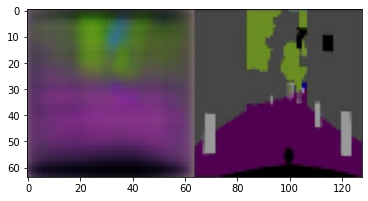

In [101]:
testset = UNETDatasetTest()

x,y = testset[34]
x = x.unsqueeze(dim = 0)
output = NET(x.to(device))
img = output.squeeze(dim = 0).permute(1,2,0).detach().cpu().numpy()
# img = x.permute(1,2,0).detach().numpy()
mask = y.permute(1,2,0).detach().numpy()

pixels = np.concatenate((img, mask), axis = 1)
plt.imshow(pixels)
